In [146]:
#pip install praw nltk textblob pandas seaborn matplotlib



In [147]:
import praw 
import pandas as pd 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
import seaborn as sns 
import matplotlib.pyplot as plt 
import re 
from tqdm.notebook import tqdm



## NLTK setup 

In [149]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tejag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tejag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Reddit API Auth

In [151]:
reddit = praw.Reddit(
    client_id = "tPu-l_r93QolWf34-3tSLQ",
    client_secret = "_wCwcdBy1kp8yGdn--uUldeAYJKUVw",
    user_agent = "RedditSentimentApp by u/Beneficial_Fly_9058"
)

## Fecth the comments 

In [153]:
def get_reddit_comments(post_url, max_comments=1000):
    submission = reddit.submission(url=post_url)
    submission.comments.replace_more(limit=None)
    
    comments_data = []
    count = 0

    print("🔍 Fetching Reddit comments...")

    for comment in submission.comments.list():
        if count >= max_comments:
            break
        comments_data.append({
            "post_id": submission.id,
            "comment_id": comment.id,
            "author": str(comment.author),
            "comment": comment.body,
            "score": comment.score,
            "created_utc": comment.created_utc
        })
        count += 1

        # Print progress every 100 comments
        if count % 100 == 0 or count == max_comments:
            print(f"✅ {count} comments fetched...")

    print(f"🎯 Done! Total comments fetched: {count}")
    return comments_data



## clean text

In [155]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\s+','',text)
    text = re.sub(r'[^a-z\s]','',text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ''.join(words)

## sentiment function 

In [157]:
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

## Fetch,Analyze & Bulid Model

In [246]:
post_url = 'https://www.reddit.com/r/ChatGPT/comments/1lwr2m2/how_we_treated_ai_in_2023_vs_2025/'
comments_raw = get_reddit_comments(post_url, max_comments=1000)

# Create DataFrame
df = pd.DataFrame(comments_raw)
df.dropna(subset=['comment'], inplace=True)

# Clean and get sentiment
df['clean_comment'] = df['comment'].apply(clean_text)
df['sentiment'] = df['clean_comment'].apply(get_sentiment)
df.head()

🔍 Fetching Reddit comments...
✅ 100 comments fetched...
✅ 200 comments fetched...
✅ 300 comments fetched...
✅ 400 comments fetched...
✅ 500 comments fetched...
✅ 600 comments fetched...
✅ 700 comments fetched...
✅ 800 comments fetched...
🎯 Done! Total comments fetched: 881


,post_id,comment_id,author,comment,score,created_utc,clean_comment,sentiment
0,1lwr2m2,n2gro6l,WithoutReason1729,Your post is getting popular and we just featu...,1,1.752194e+09,postgettingpopularfeatureddiscordcomecheckyouv...,neutral
1,1lwr2m2,n2ge3an,LevelUpCity120,Lol this is a really good depiction. These are...,2755,1.752190e+09,lolreallygooddepictioncrazytime,neutral
2,1lwr2m2,n2gg4n4,BarfingOnMyFace,This is a work of art. Beautifully done rendit...,1175,1.752190e+09,workartbeautifullydonerendition,neutral
3,1lwr2m2,n2gdk1a,driftking428,This makes me watch to re-watch Whiplash.,1885,1.752190e+09,makewatchrewatchwhiplash,neutral
4,1lwr2m2,n2gbw6e,Jfonzy,JK Simmons is terrifying,731,1.752189e+09,jksimmonsterrifying,neutral


In [248]:
df['sentiment'].value_counts()

sentiment
neutral     862
positive     17
negative      2
Name: count, dtype: int64

## TF-IDF + Logistic Regression

In [251]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [253]:
tfidf = TfidfVectorizer(max_features = 5000)
x = tfidf.fit_transform(df['clean_comment']).toarray()
y = df['sentiment']

In [255]:
from sklearn.model_selection import train_test_split

In [257]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

In [259]:
# train model 
model = LogisticRegression(max_iter = 200)
model.fit(x_train,y_train)

LogisticRegression(max_iter=200)

## Evaluate Model

In [268]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [264]:
y_pred = model.predict(x_test)

print('classification report:\n',classification_report(y_test,y_pred))
print('accuracy score:\n',accuracy_score(y_test,y_pred))

classification report:
               precision    recall  f1-score   support

     neutral       0.99      1.00      0.99       175
    positive       0.00      0.00      0.00         2

    accuracy                           0.99       177
   macro avg       0.49      0.50      0.50       177
weighted avg       0.98      0.99      0.98       177

accuracy score:
 0.9887005649717514


C:\Users\tejag\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tejag\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tejag\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


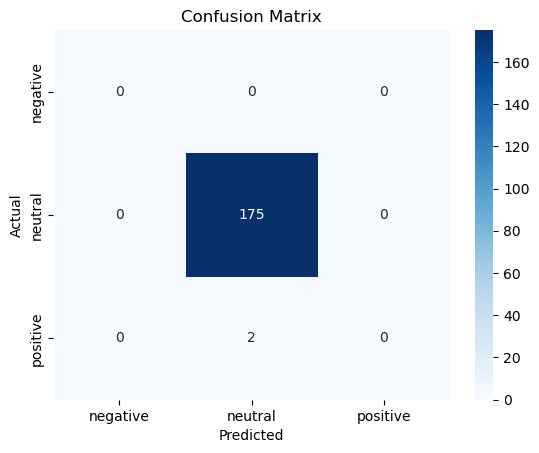

In [270]:
# confusion matirx
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##  Save Model

In [275]:
import pickle

In [279]:
with open('reddit_sentimental_model.pkl','wb') as f:
    pickle.dump(model,f)

with open('reddit_tfidf_vectorizer.pkl','wb') as f:
    pickle.dump(tfidf,f)


print("✅ Model and vectorizer saved successfully.")

✅ Model and vectorizer saved successfully.
